In [ ]:
list.of.packages <- c('tidyverse', 'reshape2', 'laGP', 'devtools')
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
library(devtools)

In [ ]:
install_github("goldingn/gpflowr")
install_github("greta-dev/greta")
install_github("greta-dev/greta.gp")

In [40]:
library(tidyverse)
library(reshape2)
tidyverse_logo()
theme_set(theme_bw())

⬢ __  _    __   .    ⬡           ⬢  . 
 / /_(_)__/ /_ ___  _____ _______ ___ 
/ __/ / _  / // / |/ / -_) __(_-</ -_)
\__/_/\_,_/\_, /|___/\__/_/ /___/\__/ 
     ⬢  . /___/      ⬡      .       ⬢ 

Equations

$ \newcommand{\prob}[1]{\mathbb{P}\!\left(#1\right)} $
$ \newcommand{\expt}[1]{\mathbb{E}\!\left[#1\right]} $
$ \newcommand{\Cov}[2]{\text{Cov}\!\left(#1,#2 \right)} $
$ \newcommand{\Var}[1]{\text{Var}\!\left(#1\right)} $
$ \newcommand{\Natural}{\mathbb{N}} $
$ \newcommand{\real}{\mathbb{R}} $
$ \newcommand{\dint}{\displaystyle\int} $
$ \newcommand{\ind}[1]{I\!\left(#1\right)} $
$ \newcommand{\bx}{\mathbb{x}} $
<!-- $ \newcommand{\normal}{\mathcal{N}} $ -->
$ \newcommand{\bigo}[1]{\mathcal{O}\!\left(#1\right)} $
$\newcommand{\data}{\mathcal{D}}$
$\newcommand{\GP}{\mathcal{GP}}$
<!-- $\newcommand{\bigo}{\mathcal{O}}$
$\newcommand{\smallo}{\mathcal{o}}$ -->
$\newcommand{\bw}{\mathbb{w}}$
$\newcommand{\normal}[2]{\mathcal{N}\!\left(#1,~#2 \right)}$
$\newcommand{\by}{\mathbb{y}}$

# Methods

## (Ordinary) GP

* 일반적인 GP
* $f \sim \GP(m, K_\theta)$에서, 크기가 $n$인 자료 $\data = (X, y)$가 주어져 있을 때 $f|\data$ 또는 $y_*|\data = f(x_*)|\data$를 추정
* kernel $K$의 모수 $\theta$의 추정으로 MAP, MLE, evidence maximization, empirical Bayes(?)를 사용한다고 함
* $\mathcal{O}(n^3)$

### Algorithm

* training data `X`, `y`
* kernel `k(,)`
* test data `Xt`

```r
K = kernel(X, X)
Ktest = kernel(Xt, Xt)
Knt = kernel(X, Xt)
L = Chol(K + sigsasq*I)
m1 = L\y
m2 = L\Knt
m = t(m2) %*% m1
L = chol(Ktest - m2 %*% t(m2))
for (s in 1:S) {
    Zs ~ N_p(0, I)
    fs = m + L %*% Zs
}
```

* output `fs ~ N(m, Ktest - m2^2)`

### Example

* Kernel: SE kernel $$K(x,y) = \exp(-||x - y||^2/2).$$
* training data: $$y_i = sin(x_i) + \epsilon_i, \quad x \in \{-4, -3, \cdots, 3\}, \quad \epsilon \sim N(0, 0.1^2)$$

In [19]:
# kernel: SE
seKernel <- function(x, y) {
  nr = length(x)
  nc = length(y)
  sqdist = matrix(x^2, nrow = nr, ncol = nc) + 
    matrix(y^2, nrow = nr, ncol = nc, byrow = TRUE) -
    2 * x %*% t(y)
  return(exp(-sqdist/2))
}

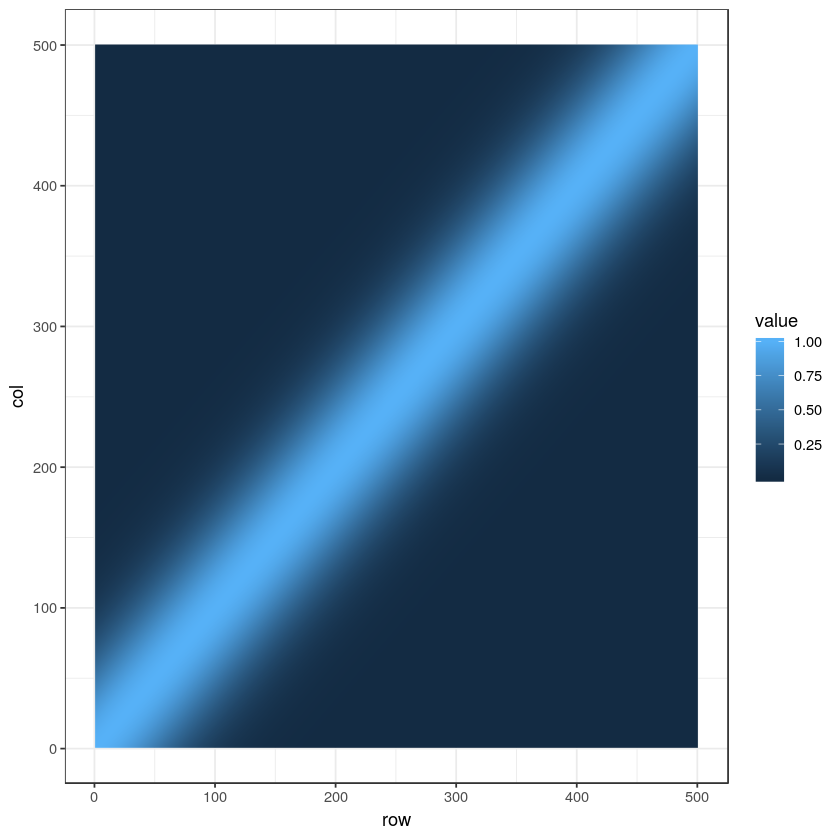

In [41]:
# test data
set.seed(100)
n <- 500
xtest <- seq(-5, 5, length = n)
K_test <- seKernel(xtest, xtest)
library(reshape2)
melt(K_test) %>%
    ggplot(aes(x = Var1, y = Var2, fill = value)) +
    geom_raster(interpolate = TRUE) +
    labs(x = "row", y = "col")

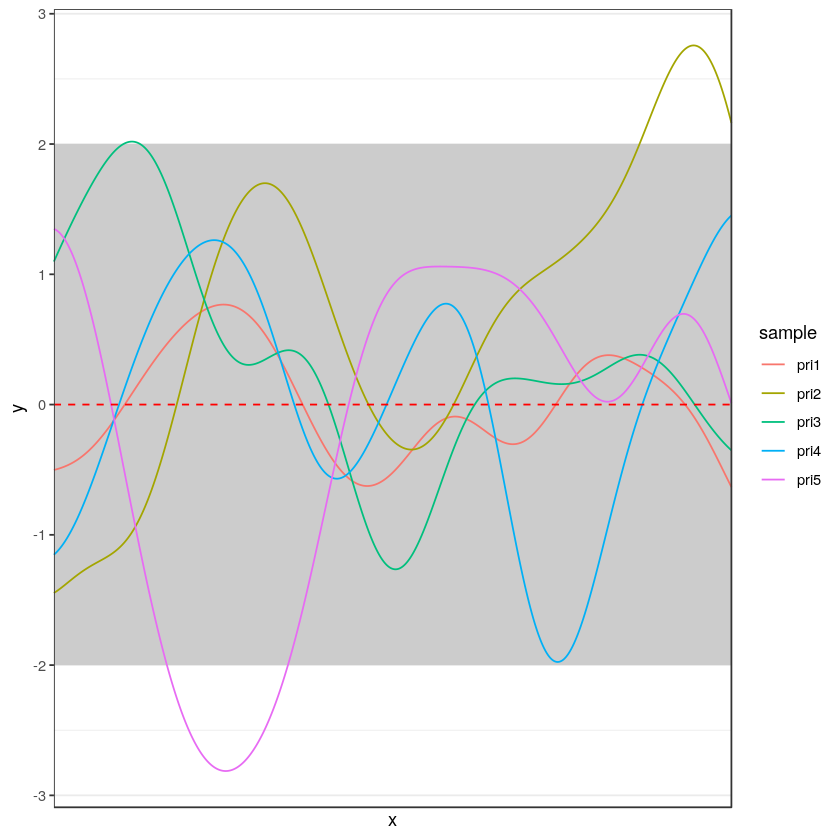

In [42]:
# draw 5 samples from prior
L_test <- chol(K_test + diag(1e-13, nrow(K_test)))
m <- 5
test_data <- data.frame(x = xtest)
for (i in 1:m) {
  test_data[[i+1]] <- t(L_test) %*% rnorm(n)
}
colnames(test_data)[-1] <- paste0("pri", 1:m)
test_data %>%
  gather(sample, y, -x) %>%
  ggplot(aes(x = x, y = y)) +
  geom_ribbon(aes(ymin = -2, ymax = 2), fill = "grey80") +
  geom_line(aes(y = y, col = sample)) +
  geom_hline(yintercept = 0, col = "red", linetype = "dashed") +
  scale_x_discrete(expand = c(0, 0))

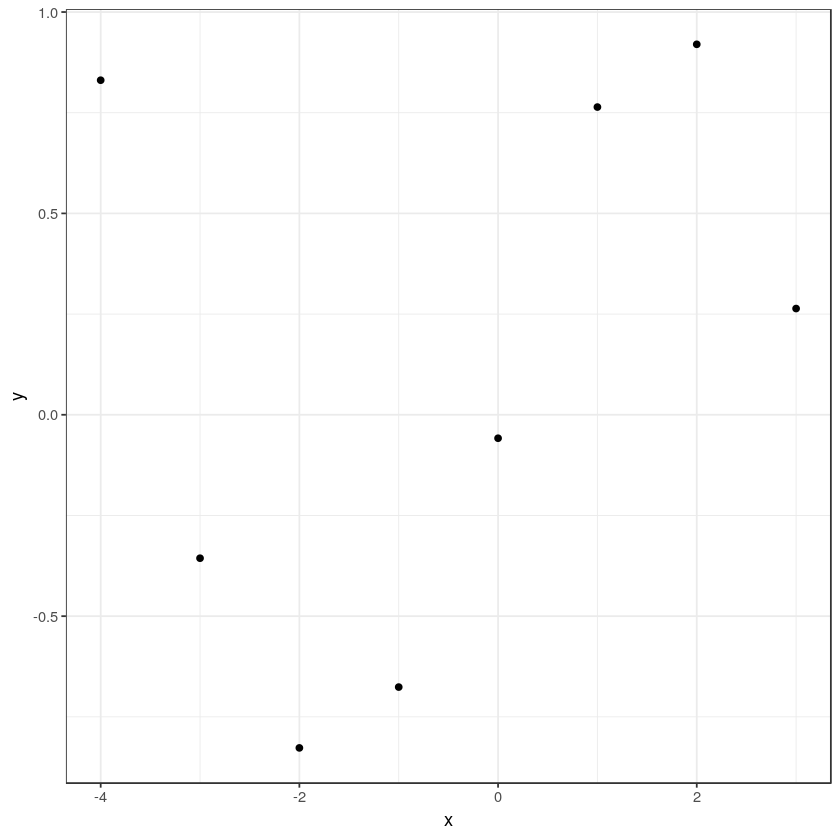

In [43]:
# training data
xtrain = seq(-4, 3, by = 1)
ytrain = sin(xtrain) + rnorm(length(xtrain), sd = 0.1)

ggplot(data = data.frame(x = xtrain, y = ytrain), aes(x = x, y = y)) +
    geom_point()

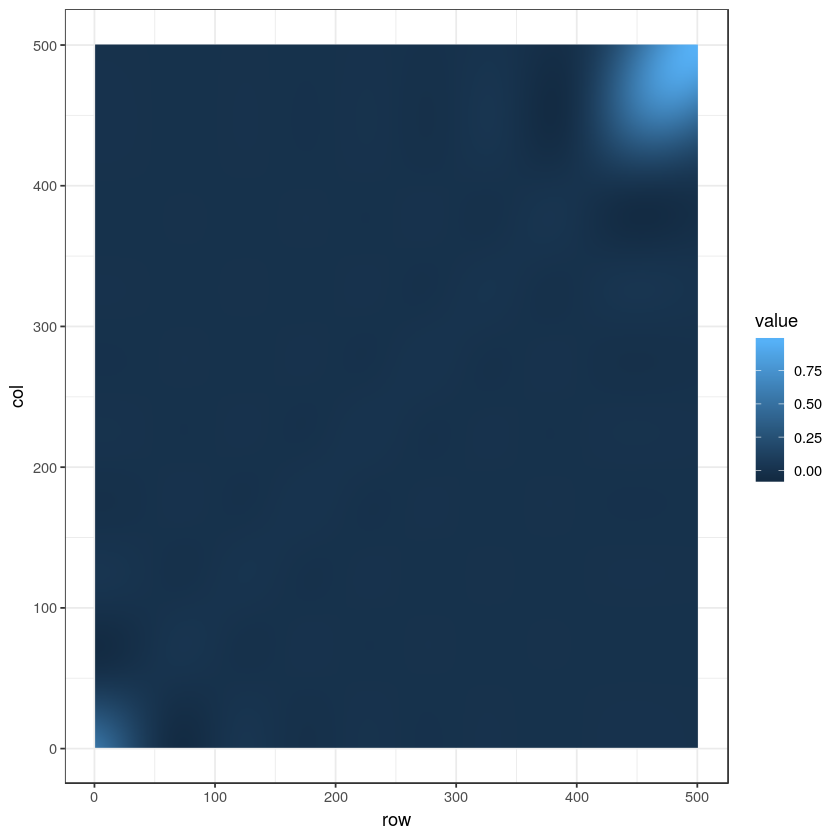

In [44]:
# calculate kernel function
K_train <- seKernel(xtrain, xtrain)
L_train <- t(chol(K_train + 1e-2*diag(length(xtrain))))

K_tratest <- seKernel(xtrain, xtest)
Lk <- solve(L_train, K_tratest)
mu = as.numeric(t(Lk) %*% solve(L_train, ytrain))
s2 <- diag(K_test) - colSums(Lk^2)
stdv = sqrt(s2)
K_train <- K_test - t(Lk) %*% Lk
L_train <- t(chol(K_train + 1e-06*diag(n)))

melt(K_train) %>%
  ggplot(aes(x = Var1, y = Var2, fill = value)) +
  geom_raster(interpolate = TRUE) +
    labs(x = "row", y = "col")

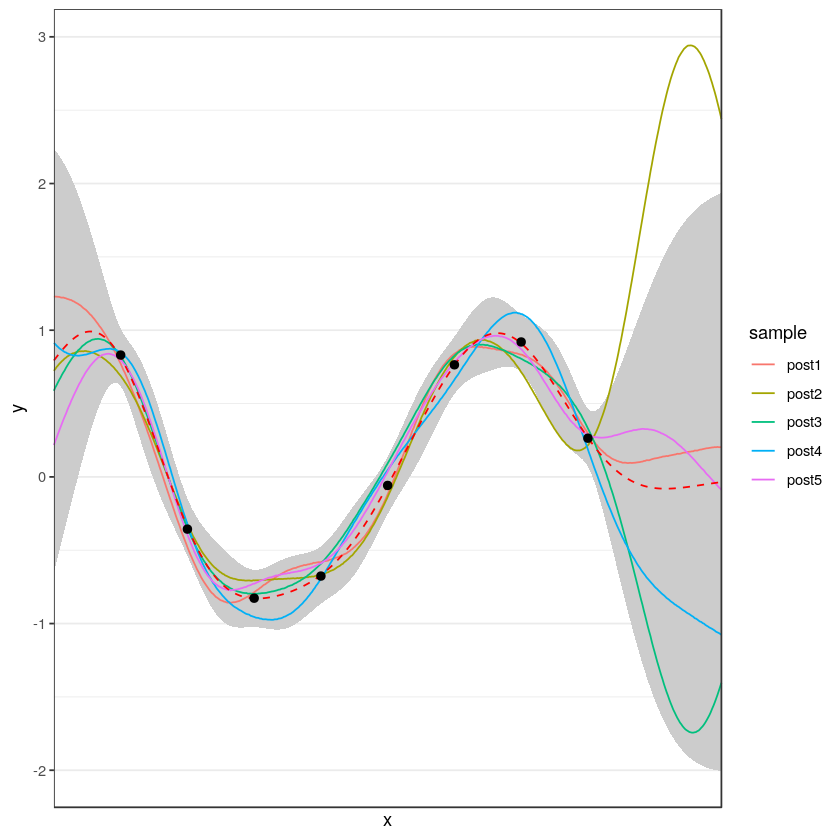

In [45]:
# draw 5 samples from posterior
m <- 5
test_data <- data.frame(x = xtest)
for (i in 1:m) {
  test_data[[i+1]] <- mu + L_train %*% rnorm(n)
}
colnames(test_data)[-1] <- paste0("post", 1:m)
test_data %>%
  gather(sample, y, -x) %>%
  ggplot(aes(x = x, y = y)) +
  geom_ribbon(data = data.frame(x = xtest, y = mu, ymin = mu-2*stdv, ymax = mu+2*stdv),
              aes(ymin = ymin, ymax = ymax), fill = "grey80") +
  geom_line(aes(y = y, col = sample)) +
  geom_line(data = data.frame(x = xtest, y = mu), col = "red", linetype = "dashed") +
  geom_point(data = data.frame(x = xtrain, y = ytrain), 
             mapping = aes(x = x, y = y), size = 2) +
  scale_x_discrete(expand = c(0, 0))

# Scalable GP

* 자료의 크기가 충분히 클 때, 쓸 수 있는 GP
* 계산의 가장 큰 병목은 Kernel matrix $K(X, X)$의 계산
* 이 부분을 해결하기 위한 다양한 알고리듬들에 대해 알아보기

## 종류

### Sparse GP

* 자료의 일부($m$)만을 사용하되, kernel matrix $K_{nn}$을 근사 $$K_{nn} \approx K_{nm}K_{mm}^{-1} K_{mn}$$
* $\bigo{nm^2}$

### Compactly Supported (CS) kernel

* 거리가 멀어지면 성분을 0으로 만들기
$$K(x_i, x_j) \leftarrow K(x_i,x_j) \ind{||x_i - x_j||<\epsilon}$$
* positive definite?
* $\bigo{\alpha n^3}$

### VI

- Variational Approximation!
- 자세한 설명은 생략

### Devide and Conquer

- 자료를 나눠서 GP를 적합하고, 마지막에 합치는 방법
- 어떻게 합치는가에 따라 다른 답을 준다.

* local kriging

## Platforms

| Language | Package  | Model                         |  GPU  |
| :------- | :------- | :---------------------------- | :---: |
| Python   | GPy      | VFE, SPEP, SKI, SVGP          |   X   |
| Python   | GPyTorch | SKI                           |   O   |
| Python/R | GPflow   | VFE, SVGP                     |   O   |
| Python   | pyMC3    | DTC, FITC, VFE                |   O   |
| R        | bigGP    |              -                |   O   |
| R        | laGP     | NeNe                          |   X   |
| R        | GPstuff  | SoR, DTC, FITC, VFE, SVGP, CS |   X   |

### Python

#### [scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html)

- Ordinary GP 만 지원하는듯

#### [gpytorch](https://gpytorch.readthedocs.io/en/latest/)

- `Pytorch` 기반
- Computation
    - GPU accelation
    - Fast predictive variances with `LOVE` ([LanczOs Variance Estimates]((https://arxiv.org/abs/1803.06058)))
- Algorithm
    - [KISS-GP](https://arxiv.org/abs/1503.01057) (Kernel Interpolation for Scalable Structured Gaussian Processes)
    - SGPR (regression)
    - SVGP (classification)
- Deep kernel

#### [GPflow](https://gpflow.readthedocs.io/en/master/index.html)

- `tensorflow` 기반
- R에서도 지원
- Model
    - Ordinary GP
      - MCMC
      - Variational Gaussian Approximation
      - GPLVM
    - Sparse GP
      - Sparse GP regression
      - Sparse MCMC
      - Sparse Variational Gaussian Approximation
      - SVIGP

### R

#### [bigGP](https://cran.r-project.org/web/packages/bigGP/index.html)

- 병렬처리, 분산처리 등을 이용해 GP 추정
- 근사를 사용하지는 않고, 계산을 용이하게 실시하는 패키지

#### [laGP](https://cran.r-project.org/web/packages/laGP/vignettes/laGP.pdf)

- local approximation (NENE)

#### [GPstuff](https://github.com/gpstuff-dev/gpstuff)

- 원래는 Matlab/Octave 전용 패키지
- `RcppOctave`을 이용해 R에서도 다룰 수 있**었**음 (현재는 패키지가 사라져 불가능, [github](https://github.com/cran/RcppOctave)에서 다운로드 받아 사용할 수는 있으나 Mac 환경에서는 추천하지 않다고 되어있음)

### Open data

![figure from Liu, H., Ong, Y.-S., Shen, X., & Cai, J. (2018). When Gaussian Process Meets Big Data: A Review of Scalable GPs. Retrieved from https://arxiv.org/pdf/1807.01065.pdf](./figs/datasets.png)

# Simulation

## What I use


laGP, GPstuff를 이용해 모형을 추정해보고, 결과를 확인해보자.
(Python을 쓸 줄 모릅니다...ㅠㅠ 공부하겠습니다)

<!-- * SGPR: M. K. Titsias. Variational learning of inducing variables in sparse Gaussian processes. In AISTATS, pages 567–574, 2009.
* SKI: A. G. Wilson and H. Nickisch. Kernel interpolation for scalable structured Gaussian processes (KISS-GP). In ICML, 2015. -->

## Data

* toy data:
    * size: $n = 2^5$ to $2^{15}$
    * *dimension: 1*
    * model: $$y = sinc(x) + \epsilon, \quad sinc(x) = \frac{sin(x)}{x},~\epsilon \sim N(0, 0.1^2) $$

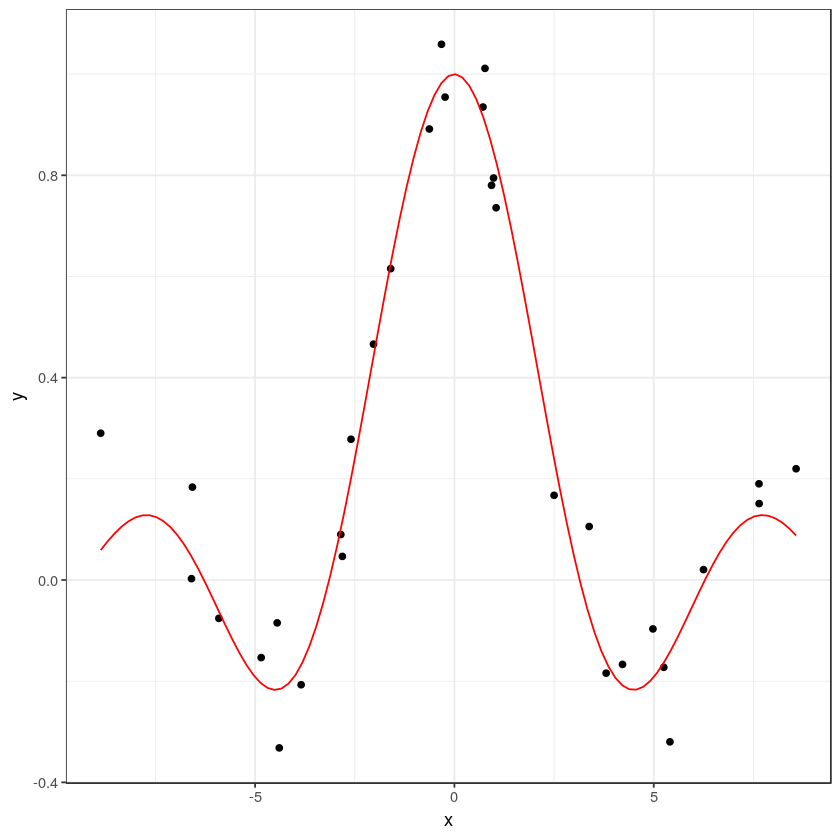

In [47]:
# example
set.seed(100)
sinc <- function(x) {
    if (x == 0) {
        return(1)
    } else {
        return(sin(x)/x)
    }
}
sinc <- Vectorize(sinc)

ex_size <- 2^5
xtrain <- runif(ex_size, min = -10, max = 10)
ytrain = sinc(xtrain) + rnorm(ex_size, sd = 0.1)

ggplot(data = data.frame(x = xtrain, y = ytrain), aes(x = x, y = y)) +
    geom_point() +
    stat_function(fun = sinc, col = "red")

# Discussion

* 많은 프로그램들이 Python 위주로 개발되고 있음
* Manifold 위에서의 GP: 공간자료 분석에서는 휘어진 공간 위에서 GP를 생각해야 할 것인데... 대부분이 실수 공간 위에서 논의되고 있음
* 두 GP간의 관계를 회귀분석으로 실시하는 방법? (공간 자료 분석에서... 미세먼지 ~ 온도 등)
* high dimensionality?
    - $p$차원 자료에서는 $\bigo{n^3 p^3}$가 되는데... 차원이 상당히 거슬릴 듯
* 딥러닝과의 연계? (Deep GP, DGP)
    - 기존의 논문에 따르면, 얇은 층의, 많은 node를 갖는 NN이 GP와 같다는 것이 알려져있음
    - NN은 end to end로 feature를 추출 $\rightarrow$ 차원을 줄일 수 있음
    - 마지막 층에 GP를 쌓아서 latent space 위에서 GP를 실시하는 방법
    - 해석이 어려움, 계산이 오래걸림
* Online-learning과 관련된 문제에 대한 생각
    - 자료가 매우 큰 경우 중 하나로 실시간으로 자료가 들어오는 상황도 있을 것 ($n(t)$)
    - 비단 GP 뿐 만이 아니고, 많은 베이즈 계산들은 근사를 사용하는데 실시간으로 사후분포를 근사할 수 있는 방법이 없을까요
    - 는 이미 있네요.. (C.-A. Cheng and B. Boots, “Incremental variational sparse Gaussian process regression,” in Advances in Neural Information Processing Systems, 2016, pp. 4410–4418.)
    - https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html
    - https://www.ki.tu-berlin.de/fileadmin/fg135/publikationen/opper/Op98b.pdf
    - https://www.inference.vc/online-bayesian-deep-learning-in-production-at-tencent/